In [1]:
from pathlib import Path

import cartopy.crs as ccrs
import iris
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
from matplotlib.colors import LogNorm
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import seaborn as sns
import shapely
from scipy.stats import linregress
import xarray as xr

from mcs_prime import mcs_prime_config_util as cu

/home/users/mmuetz/projects/mcs_prime/mcs_prime/mcs_prime_config_util.py:69: UserWarning: Warning: path missing era5dir: /does/not/exist
  warnings.warn(f"Warning: path missing {k}: {path}")


In [2]:
datadir = cu.PATHS['datadir']
simdir = datadir / 'UM_sims'
OUTDIR = cu.PATHS['outdir']

In [3]:
suites = {
    'u-dg040': 'ctrl',
    'u-dg041': 'PRIME-MCSP',
    'u-dg042': 'PRIME-stochMCSP',
    'u-cv415': 'orig-PRIME-MCSP',  
}

In [4]:


def get_daily_mean_precip_flux(nc_path):
    df = xr.open_dataset(nc_path)
    tindex = xr.CFTimeIndex(df.precipitation_flux.time_1.values)
    # precipitation_flux is included twice in this stream with different time avgs.
    # Extract the daily mean values.
    tfilter = (tindex.hour == 12) & (tindex.minute == 0)
    pflux = df.precipitation_flux.isel(dim0=tfilter)
    return pflux
    
def load_suite_data(suite):
    print(suite)
    nc_paths = sorted((simdir / suite).glob(f'{suite[2:]}a.pd*.nc'))
    print(len(nc_paths))
    pflux = xr.concat([get_daily_mean_precip_flux(p) for p in nc_paths], dim='dim0')
    return pflux

def load_suite_data2(suite):
    precip_path = OUTDIR / f'um_sims_analysis/dev/extract_precip/{suite}_extracted_precip.nc'
    return xr.open_dataarray(precip_path)
    

In [5]:
suite_data_daily = {
    suite: load_suite_data(suite)
    for suite in suites.keys()
}
suite_data = {
    suite: suite_data_daily[suite].mean(dim='dim0')
    for suite in suites.keys()
}

u-dg040
12
u-dg041
12
u-dg042
12
u-cv415
12


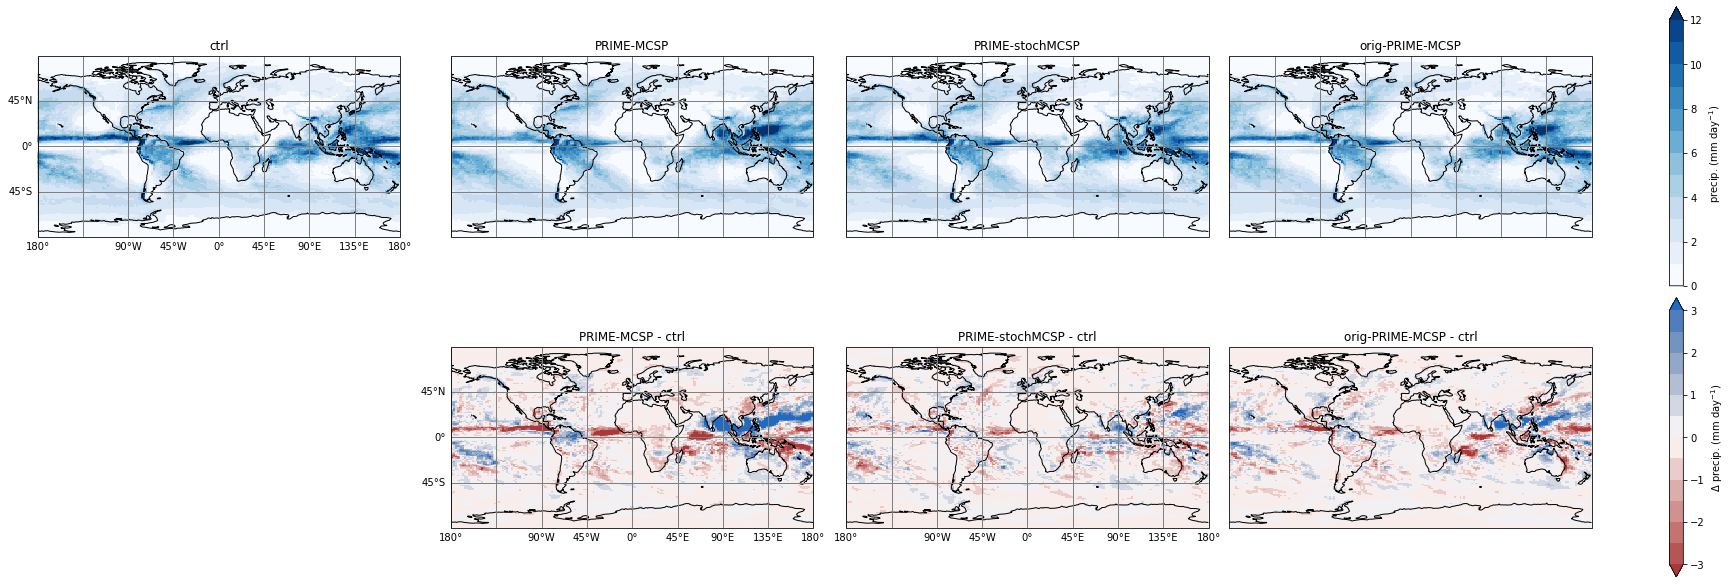

In [6]:
def plot_suites(suites, suite_data):
    fig, axes = plt.subplots(2, 4, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    cubehelix = sns.color_palette('cubehelix_r', as_cmap=True)
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24).plot(ax=ax, cmap='Blues', levels=np.linspace(0, 12, 13), add_colorbar=False)
        ax.set_title(suites[suite])
        if ax == axes[0, 0]:
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=vlag, levels=np.linspace(-3, 3, 13), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2):
            gl.left_labels = False
            

plot_suites(suites, suite_data)

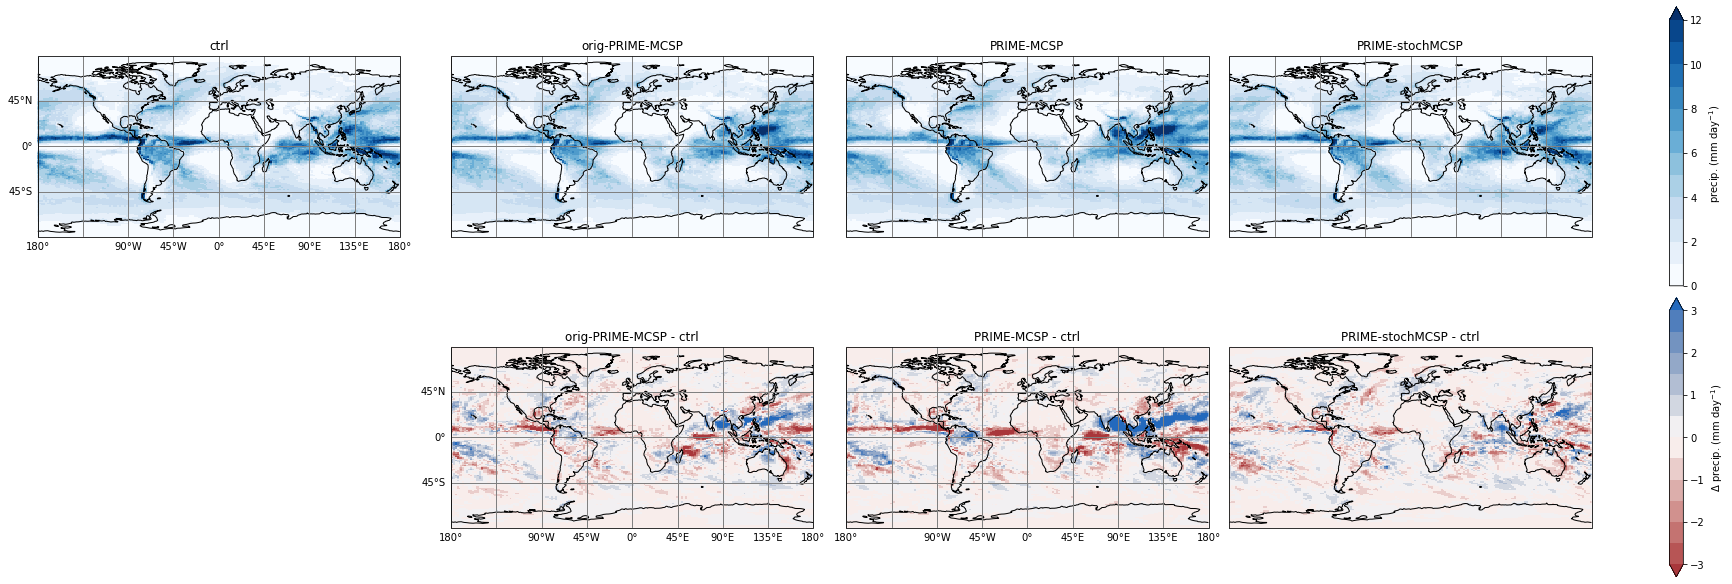

In [7]:
suites = {
    'u-dg040': 'ctrl',  
    'u-cv415': 'orig-PRIME-MCSP',  
    'u-dg041': 'PRIME-MCSP',
    'u-dg042': 'PRIME-stochMCSP',
}

plot_suites(suites, suite_data)

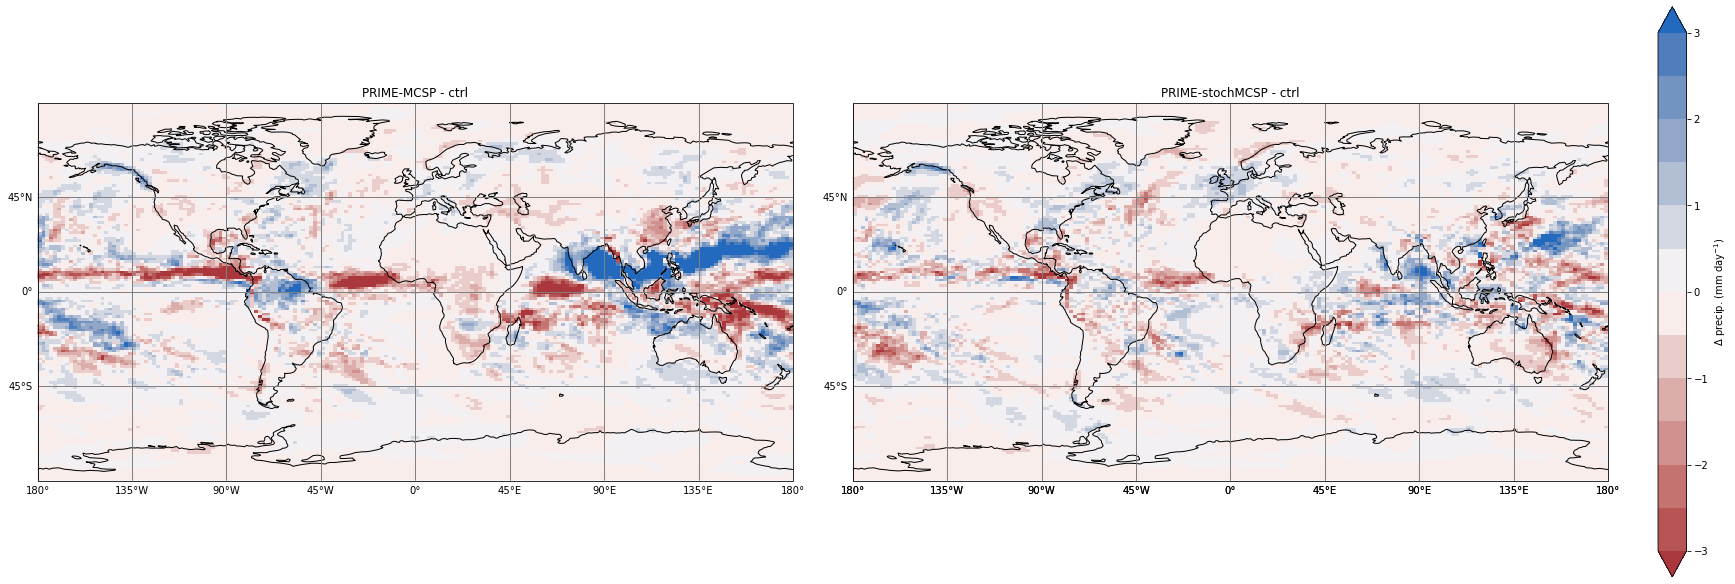

In [8]:
def plot_suites_diff_only(suites, suite_data):
    fig, axes = plt.subplots(1, 2, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    ctrl_pflux = suite_data['u-dg040']
    for suite, ax in zip(['u-dg041', 'u-dg042'], axes):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=vlag, levels=np.linspace(-3, 3, 13), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False
    for ax in axes[0:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False         

plot_suites_diff_only(suites, suite_data)

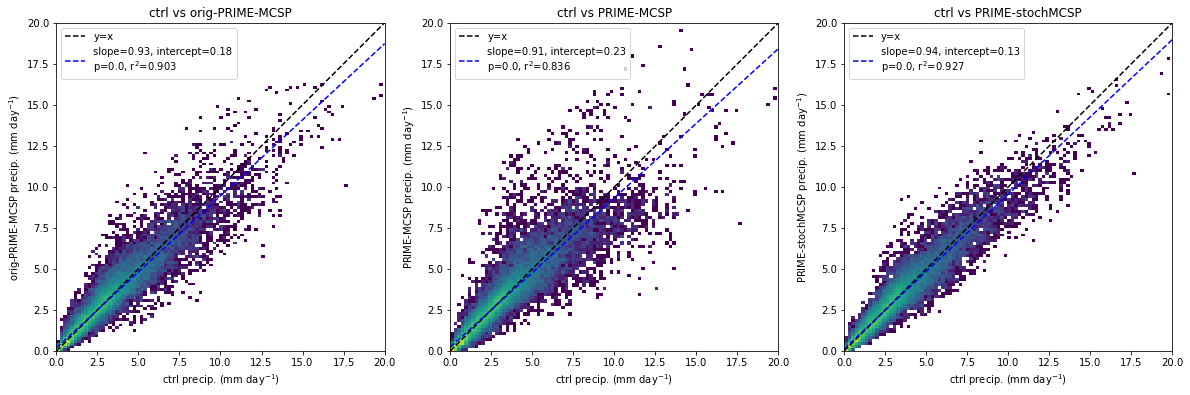

In [9]:
def plot_corr(suites, suite_data):
    ctrl_pflux = suite_data['u-dg040']
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(20, 10)
    for ax, suite in zip(axes, ['u-cv415', 'u-dg041', 'u-dg042']):
        ax.set_title(f'ctrl vs {suites[suite]}')
        pflux = suite_data[suite]
        lr = linregress(ctrl_pflux.values.flatten() * 3600 * 24, pflux.values.flatten() * 3600 * 24)
        # plt.scatter(ctrl_pflux.values.flatten() * 3600 * 24, pflux.values.flatten() * 3600 * 24)
        ax.hist2d(ctrl_pflux.values.flatten() * 3600 * 24, pflux.values.flatten() * 3600 * 24, bins=(100, 100), norm=LogNorm())
        ax.plot([0, 20], [0, 20], 'k--', label='y=x')
        ax.set_aspect('equal')
        ax.set_xlim((0, 20))
        ax.set_ylim((0, 20))
        x = np.array([0, 20])
        y = lr.slope * x + lr.intercept
        ax.plot(x, y, 'b--', label=f'slope={lr.slope:.2f}, intercept={lr.intercept:.2f}\np={lr.pvalue}, r$^2$={lr.rvalue**2:.3f}')
        ax.legend()
        ax.set_xlabel('ctrl precip. (mm day$^{-1}$)')
        ax.set_ylabel(suites[suite] + ' precip. (mm day$^{-1}$)')
        
plot_corr(suites, suite_data)

In [10]:
cmap1_colours = ['#2730d7', '#598dfc', '#8befd9', '#60cf91', '#1a9850', '#91cf60', '#d9ef8b', '#fee08b', '#fc8d59', '#d73027']
cmap1 = mpl.colors.ListedColormap(cmap1_colours)
cmap1.set_extremes(over='#960064', under='#640096')
# norm = mpl.colors.BoundaryNorm([0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], cmap.N)


In [11]:
cmap2_colours = ['#175eb8', '#3da1f0', '#6fc7fd', '#a7f1ff', '#ddfdff', '#fff5c0', '#ffc746', '#ff8800', '#ff3600', '#d20a00']
cmap2 = mpl.colors.ListedColormap(cmap2_colours)
cmap2.set_extremes(over='#a50000', under='#0a3278')
# norm = mpl.colors.BoundaryNorm([-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0], cmap2.N)

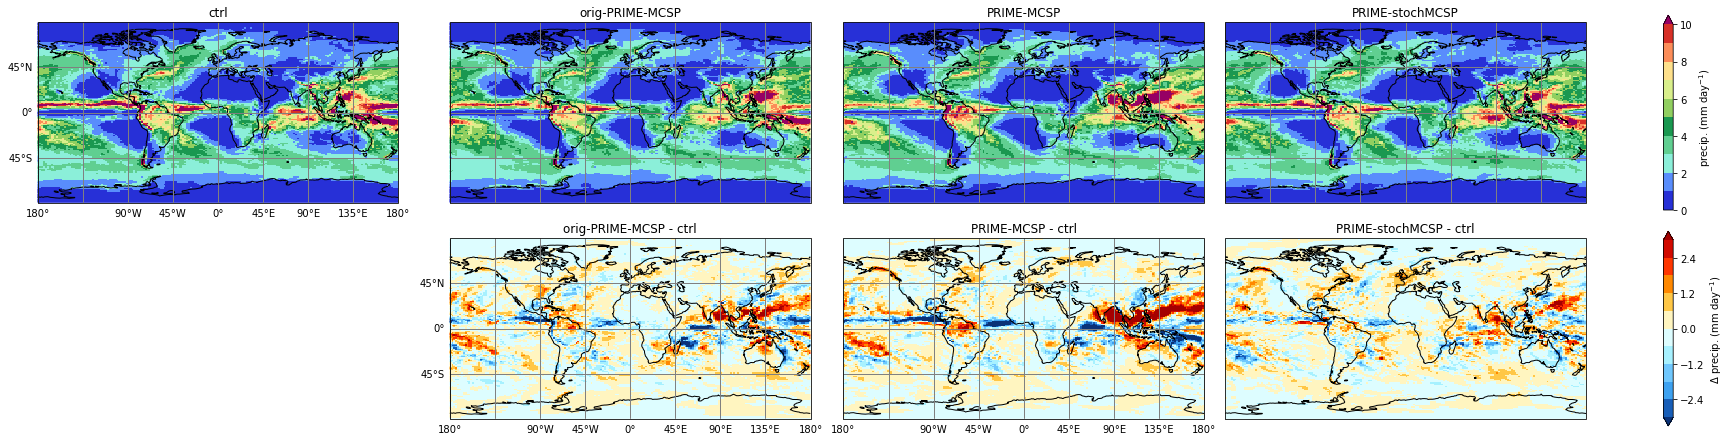

In [12]:
def plot_suites2(suites, suite_data):
    fig, axes = plt.subplots(2, 4, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 6))
    cubehelix = sns.color_palette('cubehelix_r', as_cmap=True)
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24).plot(ax=ax, cmap=cmap1, levels=np.linspace(0, 10, 11), add_colorbar=False)
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-3, 3, 11), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2):
            gl.left_labels = False
            

plot_suites2(suites, suite_data)

In [13]:
pflux_ctrl = suite_data['u-dg040']

for suite in suites.keys():
    pflux = suite_data[suite]
    print(np.abs(np.percentile(pflux.values.flatten() * 3600 * 24, 99)).max())
    print(np.abs(np.percentile((pflux.values.flatten() - pflux_ctrl.values.flatten()) * 3600 * 24, [1, 99])).max())
    

10.577704410552961
0.0
9.91709526062011
2.4189714860916136
9.740210800170894
3.4575295591354256
9.962242431640624
2.0076898860931394


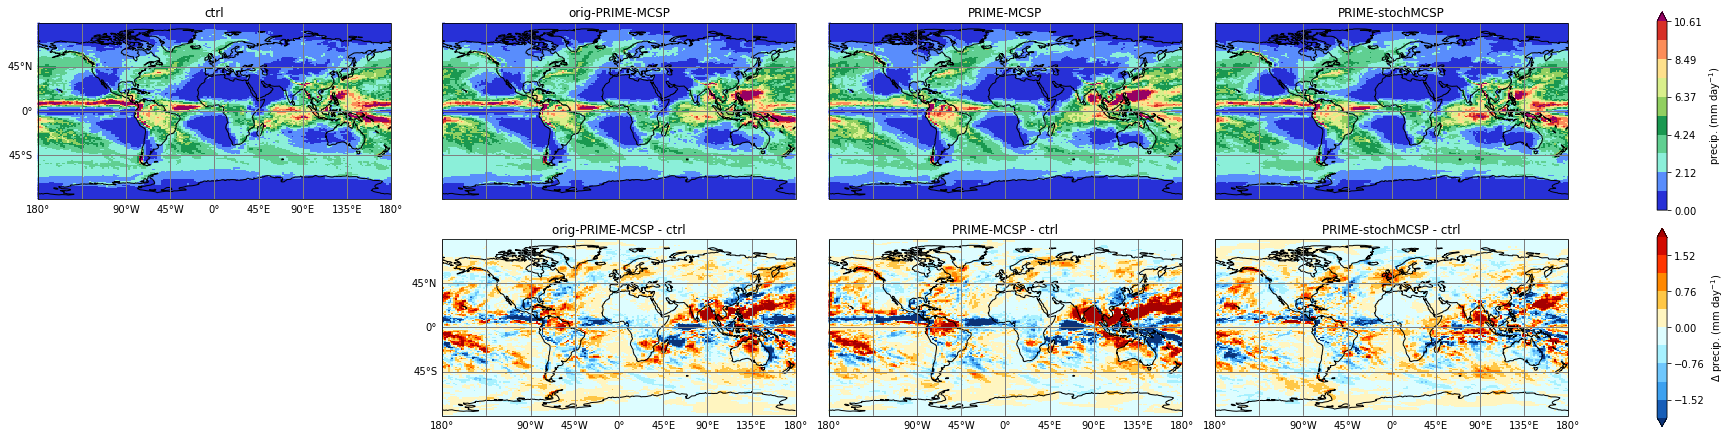

In [14]:
def plot_suites2_percentiles(suites, suite_data):
    fig, axes = plt.subplots(2, 4, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 6))
    cubehelix = sns.color_palette('cubehelix_r', as_cmap=True)
    vlag = sns.color_palette('vlag_r', as_cmap=True)
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24).plot(ax=ax, cmap=cmap1, levels=np.linspace(0, 10.608353271484361, 11), add_colorbar=False)
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-1.9, 1.9, 11), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2), (1, 3)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2) or idx == (1, 3):
            gl.left_labels = False
            

plot_suites2_percentiles(suites, suite_data)

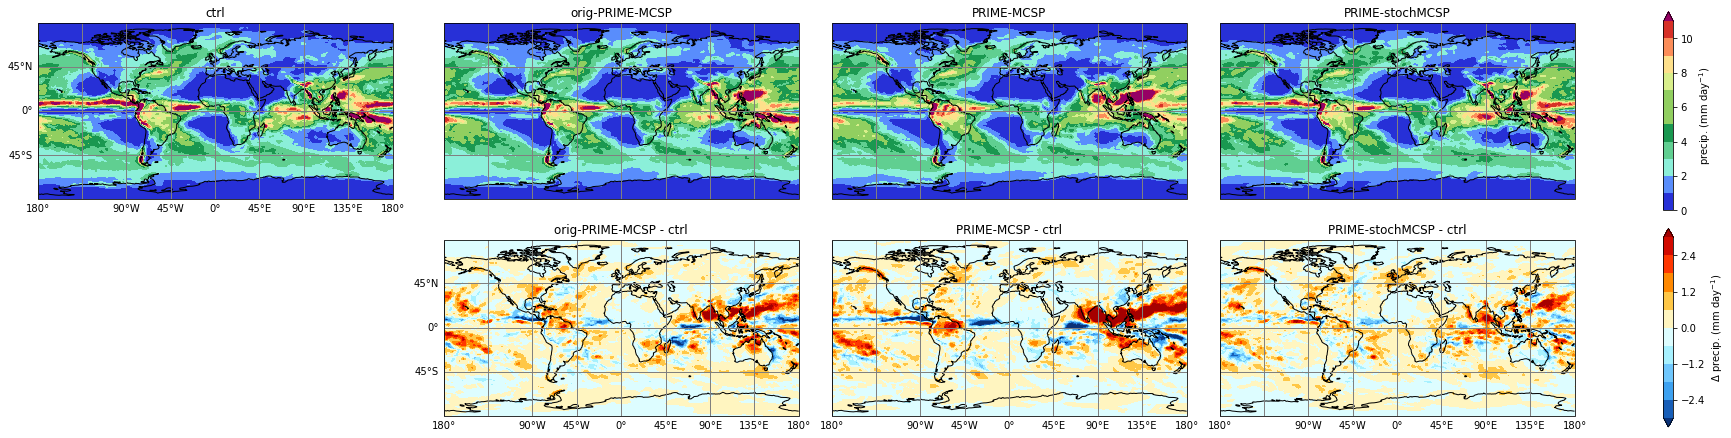

In [15]:
def plot_suites3(suites, suite_data):
    fig, axes = plt.subplots(2, 4, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 6))
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data[suite]
        # im = (pflux * 3600 * 24).plot(ax=ax, cmap=cmap, levels=np.linspace(0, 10, 11), add_colorbar=False)
        im = ax.contourf(pflux.longitude, pflux.latitude, pflux * 3600 * 24, cmap=cmap1, levels=np.linspace(0, 11, 12), extend='max')
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data[suite]
        # im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-3, 3, 11), add_colorbar=False)
        im = ax.contourf(pflux.longitude, pflux.latitude, pflux * 3600 * 24 - ctrl_pflux * 3600 * 24, cmap=cmap2, levels=np.linspace(-3, 3, 11), extend='both')
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2), (1, 3)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2) or idx == (1, 3):
            gl.left_labels = False
            

plot_suites3(suites, suite_data)

In [16]:
boxes = {
    'indian_ocean': (50, 100, -10, 10),
    'india': (70, 90, 10, 30),
    'west_pacific': (110, 170, 5, 30),
}

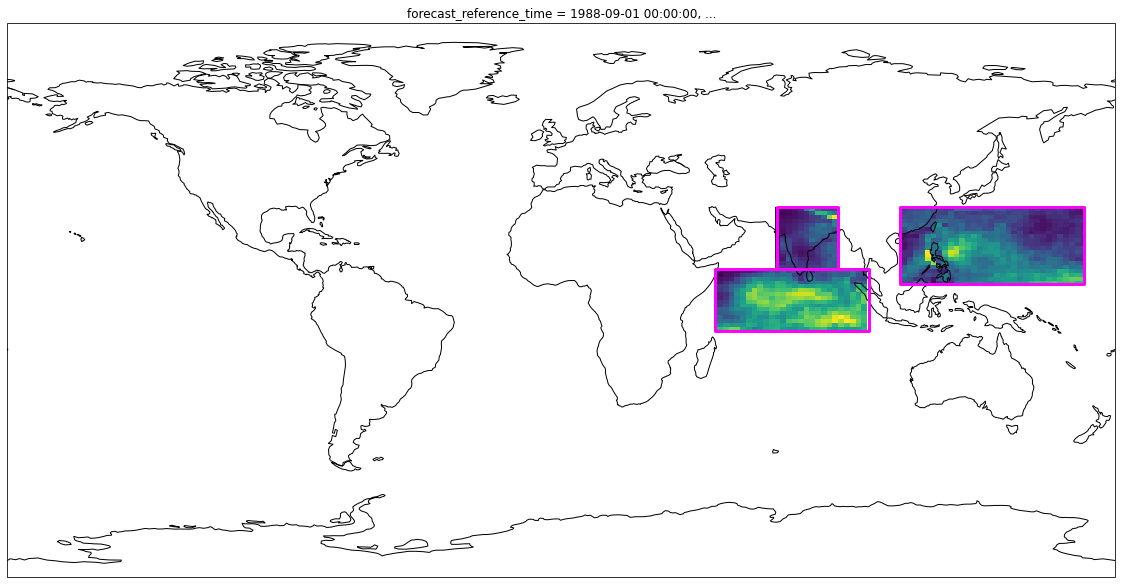

In [17]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
fig.set_size_inches((24, 8))
ax.coastlines()

for bname, bcoords in boxes.items():
    minx, maxx, miny, maxy = bcoords
    bpoints = ((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny))
    box = shapely.geometry.LinearRing(bpoints)
    # Add geometry for each nested grid size.
    ax.add_geometries([box], crs=ccrs.PlateCarree(), edgecolor='magenta', facecolor='none', lw=3)

for bname, bcoords in boxes.items():
    pflux = suite_data['u-dg040']
    minx, maxx, miny, maxy = bcoords
    pflux_box = pflux.sel(longitude=slice(minx, maxx), latitude=slice(miny, maxy))
    pflux_box.plot(ax=ax, add_colorbar=False)
ax.set_extent((-180, 180, -90, 90))


In [18]:
monthly_data = {}
# Time index is messed up due to files names of sep, oct...
pflux_daily = suite_data_daily['u-dg040']

tindex = xr.CFTimeIndex(pflux_daily.time_1.values)

for suite in suites:
    pflux_daily = suite_data_daily[suite]
    monthly_data[suite] = {}
    for bname in boxes.keys():
        monthly_data[suite][bname] = []
    for m in range(12):
        pmonth = pflux_daily.isel(dim0=tindex.month == m + 1).mean(dim='dim0')
        #print(pmonth)
        for bname, bcoords in boxes.items():
            minx, maxx, miny, maxy = bcoords
            pmonth_box = pmonth.sel(longitude=slice(minx, maxx), latitude=slice(miny, maxy))
            monthly_data[suite][bname].append(pmonth_box.values.mean() * 3600 * 24)


In [19]:
tindex = xr.CFTimeIndex(pflux_daily.time_1.values)

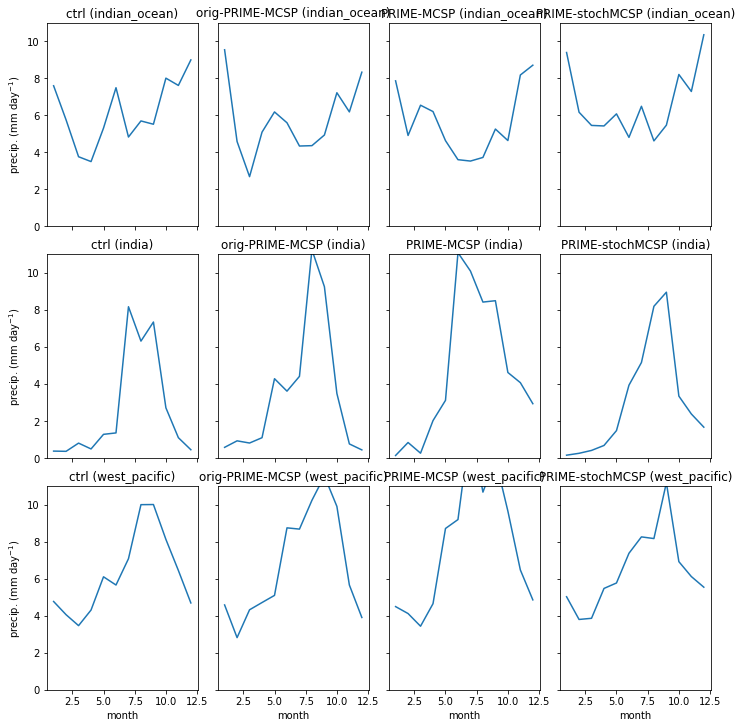

In [20]:
fig, axes = plt.subplots(3, 4, layout='constrained', sharex=True, sharey=True)
fig.set_size_inches(10, 10)
for axrow, bname in zip(axes, boxes.keys()):
    for ax, suite in zip(axrow, suites):
        ax.set_title(f'{suites[suite]} ({bname})')
        ax.plot(range(1, 13), monthly_data[suite][bname])
        ax.set_ylim((0, 11))
for ax in axes[-1]:
    ax.set_xlabel('month')
for ax in axes[:, 0]:
    ax.set_ylabel('precip. (mm day$^{-1}$)')
    

In [21]:
gpcp_dir = Path('/gws/nopw/j04/mcs_prime/zhixiao/gpcp')
# GPCPMON_L3_198809_V3.2.nc4
ym = [
    (1988, 9),
    (1988, 10),
    (1988, 11),
    (1988, 12),
    (1989, 1),
    (1989, 2),
    (1989, 3),
    (1989, 4),
    (1989, 5),
    (1989, 6),
    (1989, 7),
    (1989, 8),
]
gpcp_paths = [
    gpcp_dir / f'GPCPMON_L3_{y}{m:02d}_V3.2.nc4'
    for y, m in ym
]
[(p, p.exists()) for p in gpcp_paths]
gpcp = xr.open_mfdataset(gpcp_paths)

In [22]:
gpcp

<xarray.Dataset>
Dimensions:                   (lon: 720, lat: 360, time: 12, bnds: 2)
Coordinates:
  * lon                       (lon) float32 -179.8 -179.2 -178.8 ... 179.2 179.8
  * lat                       (lat) float32 89.75 89.25 88.75 ... -89.25 -89.75
  * time                      (time) datetime64[ns] 1988-09-01 ... 1989-08-01
Dimensions without coordinates: bnds
Data variables:
    sat_gauge_precip          (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    sat_gauge_error           (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    satellite_precip          (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    satellite_source          (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    gauge_precip              (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    probability_liquid_phase  (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    gauge_relative_weight     (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    quality_index             (time, lat, lon) float32 dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    time_bnds                 (time, bnds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
Attributes: (12/66)
    ShortName:                      GPCPMON
    LongName:                       GPCP Precipitation Level 3 Monthly 0.5-De...
    VersionID:                      3.2
    GranuleID:                      GPCPMON_L3_198809_V3.2.nc4
    Format:                         NetCDF-4
    RangeBeginningDate:             1988-09-01
    ...                             ...
    Distribution_Size:              Approximately 7 MB per file
    Distribution_Format:            NetCDF-4
    IdentifierProductDOIAuthority:  http://dx.doi.org/
    Fees:                           None
    ProcessingLevel:                Level 3
    Institution:                    Mesoscale Atmospheric Processes Laborator...

In [23]:
monthly_data['gpcp'] = {}
gpcp_tindex = pd.DatetimeIndex(gpcp.time)
for bname in boxes.keys():
    monthly_data['gpcp'][bname] = []
for m in range(12):
    pmonth = gpcp.isel(time=gpcp_tindex.month == m + 1)
    #print(pmonth)
    for bname, bcoords in boxes.items():
        minx, maxx, miny, maxy = bcoords
        pmonth_box = pmonth.sel(lon=slice(minx, maxx), lat=slice(maxy, miny))
        # monthly_data[suite][bname].append(pmonth_box.values.mean() * 3600 * 24)
        monthly_data['gpcp'][bname].append(pmonth_box.satellite_precip.values.mean())

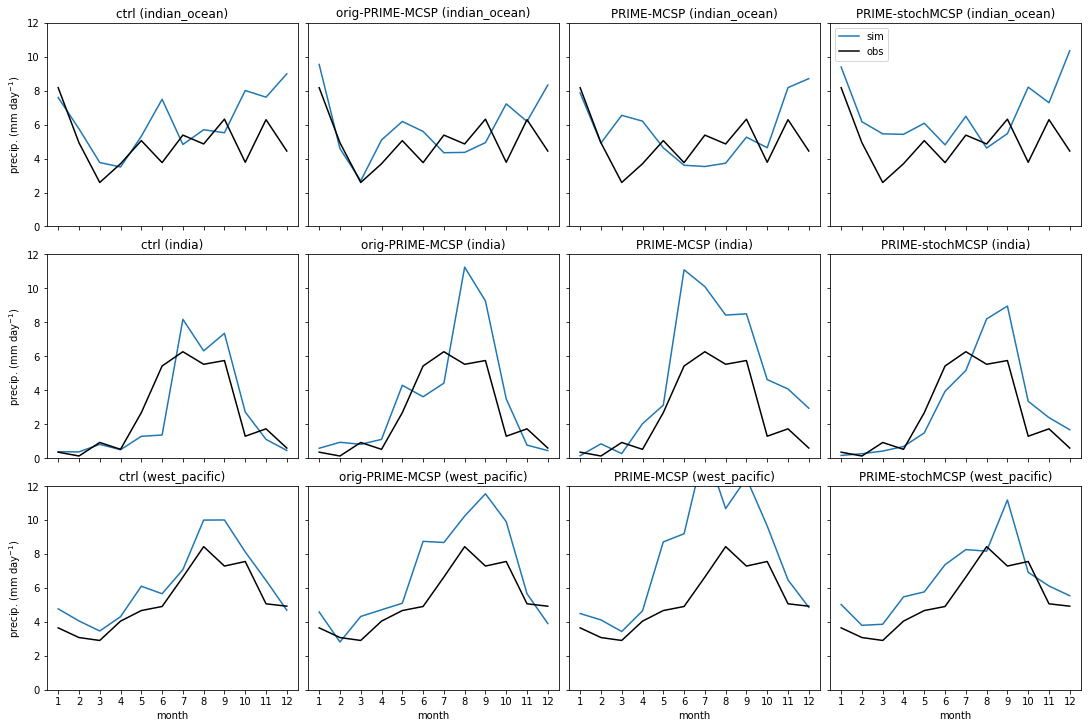

In [24]:
fig, axes = plt.subplots(3, 4, layout='constrained', sharex=True, sharey=True)
fig.set_size_inches(15, 10)
for axrow, bname in zip(axes, boxes.keys()):
    for ax, suite in zip(axrow, suites):
        ax.set_title(f'{suites[suite]} ({bname})')
        ax.plot(range(1, 13), monthly_data[suite][bname], label='sim')
        ax.plot(range(1, 13), monthly_data['gpcp'][bname], 'k', label='obs')
        ax.set_ylim((0, 12))
        ax.set_xticks(range(1, 13))
        # ax.set_xticklabels([9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8])
for ax in axes[-1]:
    ax.set_xlabel('month')
for ax in axes[:, 0]:
    ax.set_ylabel('precip. (mm day$^{-1}$)')
axes[0, -1].legend()
    

In [25]:
# gpcp.cf.bounds

In [26]:
# pflux.cf

In [27]:
# Regrid OBS
import xesmf as xe
# pflux.cf has no bounds, meaning conservative gregridding won't work for now
# Perform conservative regridding
# regridder = xe.Regridder(gpcp.satellite_precip, pflux, method='conservative')
regridder = xe.Regridder(gpcp.satellite_precip, pflux, method='bilinear')
regridded_gpcp = regridder(gpcp.satellite_precip)

# Print the regridded precipitation rate data
# print("Regridded precipitation rate data:")
print(regridded_gpcp)



/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/dask/array/core.py:456: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/home/users/mmuetz/miniconda3/envs/mcs_prime_env/lib/python3.10/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


<xarray.DataArray (time: 12, latitude: 144, longitude: 192)>
dask.array<_regrid, shape=(12, 144, 192), dtype=float32, chunksize=(1, 144, 192), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1988-09-01 1988-10-01 ... 1989-08-01
  * longitude  (longitude) float32 0.9375 2.812 4.688 ... 355.3 357.2 359.1
  * latitude   (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
Attributes:
    regrid_method:  bilinear


In [32]:
def calc_rmse(a1, a2):
    return np.sqrt(((a1 - a2)**2).mean())

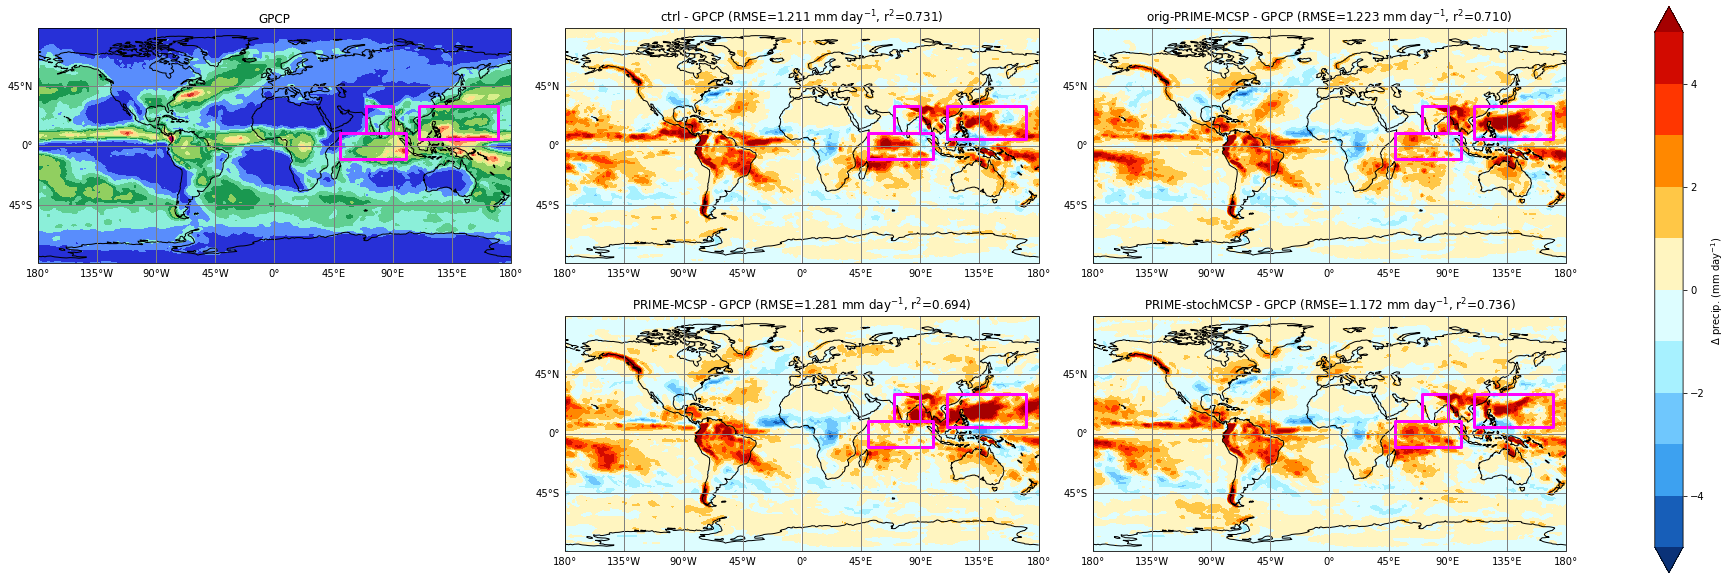

In [39]:
def plot_suites4(suites, suite_data):
    gpcp_mean = regridded_gpcp.mean(dim='time')
    fig, axes = plt.subplots(2, 3, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 8))
    axes[1, 0].axis('off')
    im = axes[0, 0].contourf(
        gpcp_mean.longitude, gpcp_mean.latitude, 
        gpcp_mean, cmap=cmap1, levels=np.linspace(0, 11, 12), extend='max'
    )
    axes[0, 0].set_title('GPCP')
    axes[0, 0].coastlines()
    
    for suite, ax in zip(suites.keys(), axes.flatten()[[1, 2, 4, 5]]):
        pflux = suite_data[suite]
        # im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-3, 3, 11), add_colorbar=False)
        im = ax.contourf(pflux.longitude, pflux.latitude, pflux * 3600 * 24 - gpcp_mean, cmap=cmap2, levels=np.linspace(-5, 5, 11), extend='both')
        rmse = calc_rmse(pflux.values * 3600 * 24, gpcp_mean.values)
        lr = linregress(pflux.values.flatten() * 3600 * 24, gpcp_mean.values.flatten())

        ax.set_title(f'{suites[suite]} - GPCP (RMSE={rmse:.3f} mm day$^{{-1}}$, r$^2$={lr.rvalue**2:.3f})')
        ax.coastlines()
    plt.colorbar(im, ax=axes, label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes.flatten()[[0, 1, 2, 4, 5]]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        
        gl.top_labels = False
        gl.right_labels = False
        for bname, bcoords in boxes.items():
            minx, maxx, miny, maxy = bcoords
            bpoints = ((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny))
            box = shapely.geometry.LinearRing(bpoints)
            # Add geometry for each nested grid size.
            ax.add_geometries([box], crs=ccrs.PlateCarree(), edgecolor='magenta', facecolor='none', lw=3)
            

plot_suites4(suites, suite_data)

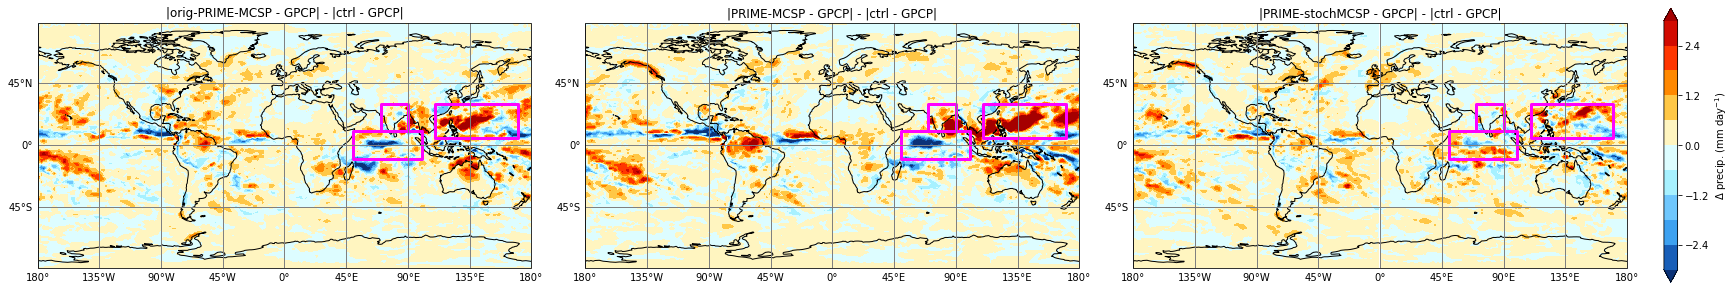

In [47]:
def plot_suites_abs_mag(suites, suite_data):
    gpcp_mean = regridded_gpcp.mean(dim='time')
    fig, axes = plt.subplots(1, 3, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 4))
    #im = axes[0, 0].contourf(
    #    gpcp_mean.longitude, gpcp_mean.latitude, 
    #    gpcp_mean, cmap=cmap1, levels=np.linspace(0, 11, 12), extend='max'
    #)
    #axes[0, 0].set_title('GPCP')
    
    pflux_ctrl = suite_data['u-dg040']
    d_ctrl = pflux_ctrl * 3600 * 24 - gpcp_mean
    for ax, expt in zip(axes, ['u-cv415', 'u-dg041', 'u-dg042']):
        pflux_expt = suite_data[expt]
        # im = (pflux * 3600 * 24 - ctrl_pflux * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-3, 3, 11), add_colorbar=False)
        d_expt = pflux_expt * 3600 * 24 - gpcp_mean
        im = ax.contourf(pflux.longitude, pflux.latitude, np.abs(d_expt.values) - np.abs(d_ctrl.values), cmap=cmap2, levels=np.linspace(-3, 3, 11), extend='both')
        ax.set_title(f'|{suites[expt]} - GPCP| - |ctrl - GPCP|')

    plt.colorbar(im, ax=ax, label='$\Delta$ precip. (mm day$^{-1}$)')

    for ax in axes:
        ax.coastlines()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        
        gl.top_labels = False
        gl.right_labels = False
        for bname, bcoords in boxes.items():
            minx, maxx, miny, maxy = bcoords
            bpoints = ((minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny))
            box = shapely.geometry.LinearRing(bpoints)
            # Add geometry for each nested grid size.
            ax.add_geometries([box], crs=ccrs.PlateCarree(), edgecolor='magenta', facecolor='none', lw=3)
            

plot_suites_abs_mag(suites, suite_data)

In [29]:
pflux_ctrl = suite_data_daily['u-dg040'].std(dim='dim0')

for suite in suites.keys():
    pflux = suite_data_daily[suite].std(dim='dim0')
    print(np.abs(np.percentile(pflux.values.flatten() * 3600 * 24, 99)).max())
    print(np.abs(np.percentile((pflux.values.flatten() - pflux_ctrl.values.flatten()) * 3600 * 24, [1, 99])).max())
    

16.724859962463345
0.0
14.505309648513792
5.670014219284058
14.797509269714345
7.264492239952087
14.740893764495846
5.023476347923279


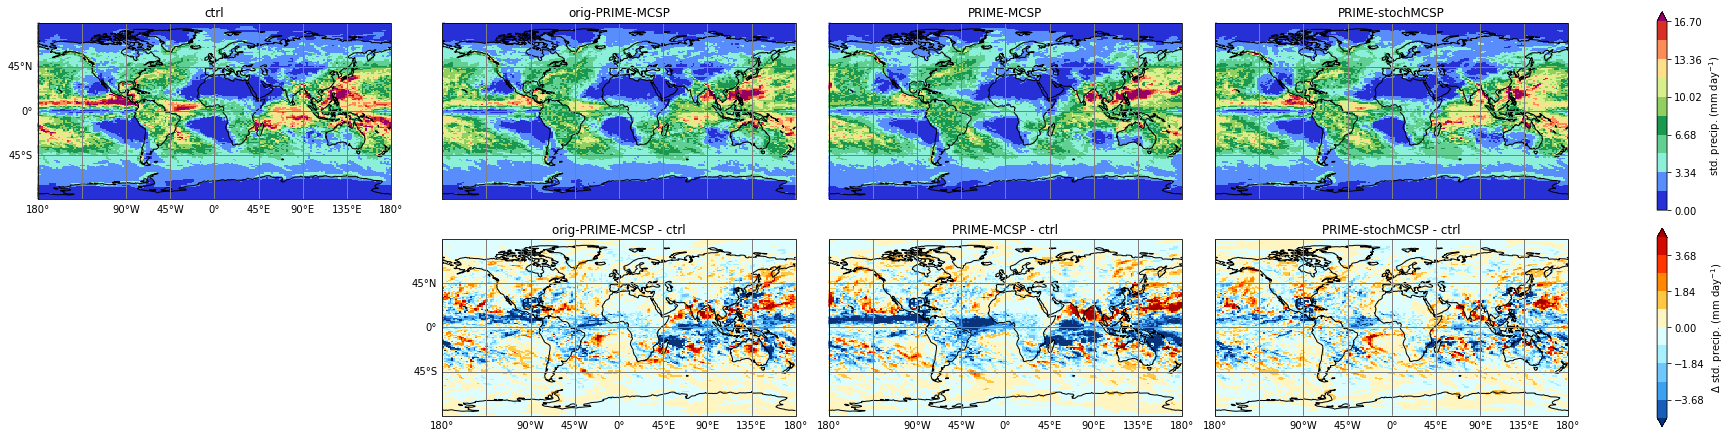

In [30]:
def plot_suites5(suites, suite_data):
    fig, axes = plt.subplots(2, 4, subplot_kw={'projection': ccrs.PlateCarree()}, layout='constrained')
    fig.set_size_inches((24, 6))
    axes[1, 0].axis('off')
    for suite, ax in zip(suites.keys(), axes[0]):
        pflux = suite_data_daily[suite]
        im = (pflux.std(dim='dim0') * 3600 * 24).plot(ax=ax, cmap=cmap1, levels=np.linspace(0, 16.7, 11), add_colorbar=False)
        ax.set_title(suites[suite])
        if suites[suite] == 'ctrl':
            ctrl_pflux = pflux
        ax.coastlines()
    plt.colorbar(im, ax=axes[0], label='std. precip. (mm day$^{-1}$)')
    for suite, ax in zip(suites.keys(), axes[1]):
        if suites[suite] == 'ctrl':
            continue
        pflux = suite_data_daily[suite]
        im = (pflux.std(dim='dim0') * 3600 * 24 - ctrl_pflux.std(dim='dim0') * 3600 * 24).plot(ax=ax, cmap=cmap2, levels=np.linspace(-4.6, 4.6, 11), add_colorbar=False)
        ax.set_title(f'{suites[suite]} - ctrl')
        ax.coastlines()
    plt.colorbar(im, ax=axes[1], label='$\Delta$ std. precip. (mm day$^{-1}$)')

    for ax in axes[0, 1:]:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
    for idx in [(0, 0), (1, 1), (1, 2), (1, 3)]:
        ax = axes[idx]
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray')
        gl.xlocator = mticker.FixedLocator(np.arange(-180, 181, 45))
        gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 45))
        gl.top_labels = False
        gl.right_labels = False
        if idx == (1, 2) or idx == (1, 3):
            gl.left_labels = False
            

plot_suites5(suites, suite_data)

In [31]:
raise Exception('dev code below')

Exception: dev code below

In [ ]:
pflux0 = suite_data['u-dg040']

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches((12, 5))
(pflux0 * 3600 * 24).plot(ax=ax, cmap='plasma', levels=np.linspace(0, 15, 16), add_colorbar=False)
ax.set_title('ctrl')
ax.coastlines()

In [ ]:
pd_paths = sorted((simdir / 'u-dg040').glob('dg040a.pd*.pp'))
nc_paths = sorted((simdir / 'u-dg040').glob('dg040a.pd*.nc'))

In [ ]:
# df = xr.open_mfdataset(nc_paths)


In [ ]:
# Necessary to get just precipitation_flux that has been averaged daily.
pflux_hour_12 = iris.Constraint(name='precipitation_flux', time=lambda cell: (cell.point.hour == 12) and (cell.point.minute == 0))
cubes = iris.load(pd_paths[:3], constraints=pflux_hour_12)

In [ ]:
pflux_cube = cubes[0]
da = xr.DataArray.from_iris(pflux_cube)

In [ ]:
df = xr.open_dataset(nc_paths[0])
tindex = xr.CFTimeIndex(df.precipitation_flux.time_1.values)
tfilter = (tindex.hour == 12) & (tindex.minute == 0)
pflux = df.precipitation_flux.isel(dim0=tfilter)
pflux

In [ ]:
def get_daily_mean_precip_flux(nc_path):
    df = xr.open_dataset(nc_path)
    tindex = xr.CFTimeIndex(df.precipitation_flux.time_1.values)
    tfilter = (tindex.hour == 12) & (tindex.minute == 0)
    pflux = df.precipitation_flux.isel(dim0=tfilter)
    return pflux

In [ ]:
pflux = xr.concat([get_daily_mean_precip_flux(p) for p in nc_paths], dim='dim0')

In [ ]:
pflux.mean(dim='dim0').plot()